In [1]:
import data
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline

## load files for all cell types

In [2]:
# list types of cells
subsets = data.prep_filename_metadata()
subsets['SubSet'].unique()
all_types = list(subsets['SubSet'].unique())
print(all_types)

['CD4_Th2', 'CD8_Effector', 'B_CD5', 'B_Memory', 'CD4_Th1', 'CD4_Naive', 'B_Naive', 'CD4_Effector_Memory', 'CD8_Central_Memory', 'CD4_Central_Memory', 'CD4_Treg', 'CD8_Naive', 'CD4_Th17']


In [3]:
df = data.load_by_cell_type(all_types, metadata=subsets)

In [4]:
df = data.prep_annotated_data(df)

In [5]:
assert all(pd.notnull(df['log1p_tpm_rescaled']))

In [6]:
df.head()

,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6,CCR7,CD127,...,CD45RO,CD5,CD8,CRTH2,CXCR3,SubSet,cell_type,log1p_tpm_rescaled_type,log1p_tpm_rescaled_subset,log1p_tpm_rescaled
0,1,ERR431566,A1BG,56.743290,6.931783,2.070878,4.056007,None,None,None,...,None,None,None,+,-,CD4_Th2,CD4,-5.599303,-3.517738,-5.478180
1,1,ERR431566,A1CF,5.194920,0.111335,0.105562,1.823730,None,None,None,...,None,None,None,+,-,CD4_Th2,CD4,-1.164584,-1.529020,-0.735391
2,1,ERR431566,A2M,10.000009,3.877857,1.584706,2.397896,None,None,None,...,None,None,None,+,-,CD4_Th2,CD4,1.338389,-0.920287,1.188265
3,1,ERR431566,A2ML1,9.387660,1.860813,1.051106,2.340619,None,None,None,...,None,None,None,+,-,CD4_Th2,CD4,1.092135,1.947468,0.895292
4,1,ERR431566,A2MP1,31.000030,3.441394,1.490968,3.465737,None,None,None,...,None,None,None,+,-,CD4_Th2,CD4,1.945796,4.135726,1.532385


## sim-data for Naive-B cells

For data-simulation, we first need to map each gene_name to a numeric ID. 


In [7]:
df['gene_cat'] = df['gene_name'].astype('category')
df['gene_id'] = df['gene_cat'].cat.codes+1

In [8]:
df.head()

,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6,CCR7,CD127,...,CD8,CRTH2,CXCR3,SubSet,cell_type,log1p_tpm_rescaled_type,log1p_tpm_rescaled_subset,log1p_tpm_rescaled,gene_cat,gene_id
0,1,ERR431566,A1BG,56.743290,6.931783,2.070878,4.056007,None,None,None,...,None,+,-,CD4_Th2,CD4,-5.599303,-3.517738,-5.478180,A1BG,1
1,1,ERR431566,A1CF,5.194920,0.111335,0.105562,1.823730,None,None,None,...,None,+,-,CD4_Th2,CD4,-1.164584,-1.529020,-0.735391,A1CF,2
2,1,ERR431566,A2M,10.000009,3.877857,1.584706,2.397896,None,None,None,...,None,+,-,CD4_Th2,CD4,1.338389,-0.920287,1.188265,A2M,3
3,1,ERR431566,A2ML1,9.387660,1.860813,1.051106,2.340619,None,None,None,...,None,+,-,CD4_Th2,CD4,1.092135,1.947468,0.895292,A2ML1,4
4,1,ERR431566,A2MP1,31.000030,3.441394,1.490968,3.465737,None,None,None,...,None,+,-,CD4_Th2,CD4,1.945796,4.135726,1.532385,A2MP1,5


Next, we restrict ourselves to the "Naive B" cell subtype

And, calculate the (geometric) mean & std for expression for each gene type

In [9]:
naive_b = df.loc[df['SubSet'] == 'B_Naive',:].copy()
naive_b['gmean'] = naive_b.groupby('gene_id')['log1p_tpm'].transform(data.gmean)
naive_b['gstd'] = naive_b.groupby('gene_id')['log1p_tpm'].transform(data.gstd)
naive_b = naive_b.loc[:,['gene_id', 'gmean', 'gstd']].drop_duplicates()

In [10]:
naive_b.head()

,gene_id,gmean,gstd
1010128,1,2.700162,0.149558
1010129,2,0.240400,0.122590
1010130,3,0.331553,0.334136
1010131,4,0.877508,0.207555
1010132,5,0.123627,0.124963


Finally, simulate data for each of these genes, assuming `N_cell` cells:

In [11]:
def sim_data(row, n_cell=1):
    if (row['gstd'] == 0).all():
        log1p_tpm = np.repeat(0, n_cell)
    else:
        log1p_tpm = np.log1p(np.random.normal(loc=np.expm1(row['gmean']),
                                              scale=np.expm1(row['gstd']),
                                              size=n_cell))
    return pd.DataFrame({'log1p_tpm': log1p_tpm})

sim_data(naive_b.iloc[0,:])

,log1p_tpm
0,2.687261


In [12]:
simd = naive_b.groupby('gene_id').apply(sim_data, n_cell=5)

In [13]:
simd.reset_index(inplace=True)

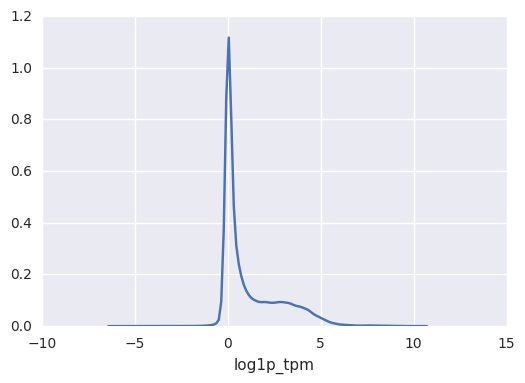

In [14]:
sns.distplot(simd['log1p_tpm'], hist=False)

## sim data for all cell types

In [15]:
df['gmean'] = df.groupby(['SubSet','gene_id'])['log1p_tpm'].transform(data.gmean)
df['gstd'] = df.groupby(['SubSet','gene_id'])['log1p_tpm'].transform(data.gstd)
df_subset = df.loc[:,['SubSet','gene_id', 'gmean', 'gstd']].drop_duplicates()

In [16]:
simd_subset = df_subset.groupby(['SubSet','gene_id']).apply(sim_data, n_cell=5)

In [17]:
simd_subset.reset_index(inplace=True)
simd_subset.head()

,SubSet,gene_id,level_2,log1p_tpm
0,B_CD5,1,0,2.724002
1,B_CD5,1,1,2.718236
2,B_CD5,1,2,2.722659
3,B_CD5,1,3,2.710996
4,B_CD5,1,4,2.707579


In [18]:
df['gmean'] = df.groupby(['cell_type','gene_id'])['log1p_tpm'].transform(data.gmean)
df['gstd'] = df.groupby(['cell_type','gene_id'])['log1p_tpm'].transform(data.gstd)
df_type = df.loc[:,['cell_type','gene_id', 'gmean', 'gstd']].drop_duplicates()

In [19]:
simd_type = df_type.groupby(['cell_type','gene_id']).apply(sim_data, n_cell=5)
simd_type.reset_index(inplace=True)

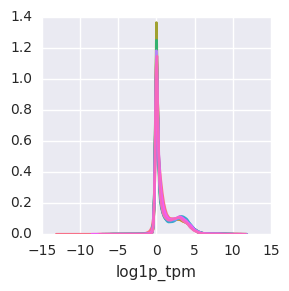

In [20]:
g = sns.FacetGrid(data=simd_subset, hue='SubSet')
g.map(sns.distplot, 'log1p_tpm', hist=False)

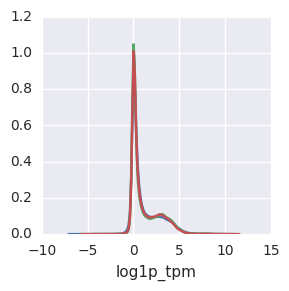

In [21]:
g = sns.FacetGrid(data=simd_type, hue='cell_type')
g.map(sns.distplot, 'log1p_tpm', hist=False)